In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator
import pickle as pkl
import time

from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

np.set_printoptions(linewidth=150)
pd.set_option('display.max_columns', 500)

from graph2net.parser import parse

In [2]:
def macro_process(predictor_df):
    losses = predictor_df[predictor_df['epoch']>=500].append(predictor_df.iloc[-1])
    losses['curve']=losses['curve'].apply(lambda x: x+[max(x)]*12 if len(x)==500 else x)
    losses['curve']=losses['curve'].apply(lambda x: x[:512] if len(x)>512 else x)
    losses['reductions']=losses['cell_types'].apply(sum)
    losses['parallel']=losses['cell_matrices'].apply(lambda x: len(x) if len(x)<3 else 1)
    losses['cells']=losses['cell_types'].apply(len)
    losses['nodes']=losses['cell_matrices'].apply(lambda x: len(x[0]) if len(x)<3 else len(x))
    losses['cell']=losses['cell_matrices'].apply(lambda x: np.array(x[0]) if len(x)<3 else np.array(x))
    losses['lr_max']=losses['lr_schedule'].apply(lambda x: x['lr_max'])
    losses['fill']=losses['cell'].apply(lambda x: len(np.triu(x).nonzero()[0])/x.size)

    losses = losses[losses['reductions']>4]
    for i in range(512):
        if i==0:
            losses['max_curve_{}'.format(i)]=losses['curve'].apply(lambda x:x[0])
        else:
            losses['max_curve_{}'.format(i)]=losses['curve'].apply(lambda x: max(x[:i+1]))
    return losses


# See Best/Last Runs

In [3]:
run_stats = parse()

In [4]:
for key,val in run_stats.sort_values(by='max',ascending=False).iloc[0].items():
    if key=='curve' or key=='predictions':
        continue
    print(key,val)

auxiliaries [1, 2, 3, 4]
auxillaries nan
cell_matrices [array([[ 0,  3,  0,  1],
       [ 0,  0, 13,  0],
       [ 0,  0,  0,  2],
       [ 0,  0,  0,  0]])]
cell_types [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
data nan
drop_path False
early_terminate False
epoch 1024
epochs 1024.0
log True
lr 0.025
lr_schedule {'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01, 't_0': 1, 't_mult': 2}
max 9509.0
mem_size 6337593344.0
momentum 0.9
params 22791538.0
per_epoch_time 54.43 s
prefix Manual
residual_cells nan
run_date 2019-02-27 02:56:22
scale 7.0
scales (2.0, 0.5)
time_taken    16 hrs, 31 mins, 50 s
track_progess nan
track_progress True
verbose False
weight_decay 0.0003


In [5]:
for key,val in run_stats.iloc[-1].items():
    if key=='curve' or key=='predictions':
        continue
    print(key,val)

auxiliaries [1, 2, 3, 4]
auxillaries nan
cell_matrices [array([[ 0.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  4.,  5.],
       [ 0.,  0.,  0., 10., 14.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.]])]
cell_types [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1]
data nan
drop_path False
early_terminate False
epoch 4
epochs 128.0
log True
lr 0.025
lr_schedule {'type': 'cosine', 'lr_min': 0, 'lr_max': 0.01, 't_0': 1, 't_mult': 2}
max 7231.0
mem_size 9538895872.0
momentum 0.9
params 35836594.0
per_epoch_time 1 min, 34 s
prefix Macro
residual_cells nan
run_date 2019-02-27 11:24:34
scale 7.0
scales (2.0, 0.5)
time_taken None
track_progess nan
track_progress True
verbose False
weight_decay 0.0003


In [6]:
def next_powers(x):
    return [2**i for i in range(1,10) if (2**i)>x]

def benchmark(y,text,color):
    plt.plot(range(520),[y]*520,linestyle="dotted",color=color,label=text) 
    plt.annotate(text,xy=(-9+(1 if len(text)==2 else 0),y-10),color=color)
    plt.annotate(text,xy=(520-(0 if len(text)==2 else 1),y-10),color=color)

def cumul_max(l):
    return np.array([l[0] if i==0 else max(l[:i]) for i in range(len(l)+1)])

def restart_delta(ls,t):
    powers = next_powers(t)
    deltas = [(power,np.mean([max(x[:power])-max(x[:t]) for x in ls])) for power in powers]
    return ", ".join(["{}: {:>4}".format(p,del_str(x)) for (p,x) in deltas])

def del_str(val):
    return "{}{:.0f}".format("+" if val>0 else "",val)

record = run_stats[run_stats['max']==max(run_stats[run_stats['epoch']==512]['max'])].iloc[0]
best_run_df = run_stats[run_stats['curve'].apply(lambda x: len(x)>125)]
best_run_df = best_run_df[best_run_df['curve'].apply(lambda x: max(x)>9000)]
best_run_df = best_run_df.sort_values(by='max',ascending=False)

# See Current Run

311
Epoch 311, Current Score: 9140, Max Score: 9401, Record Score: 9500
Current Record Delta:      -66 (9140 vs 9206), Average T-10 Delta: -8
Current Record Max Delta:  -30 (9401 vs 9431)
Average Delta to Restart: 512:  +57
Record  Delta to Restart: 512:  +69


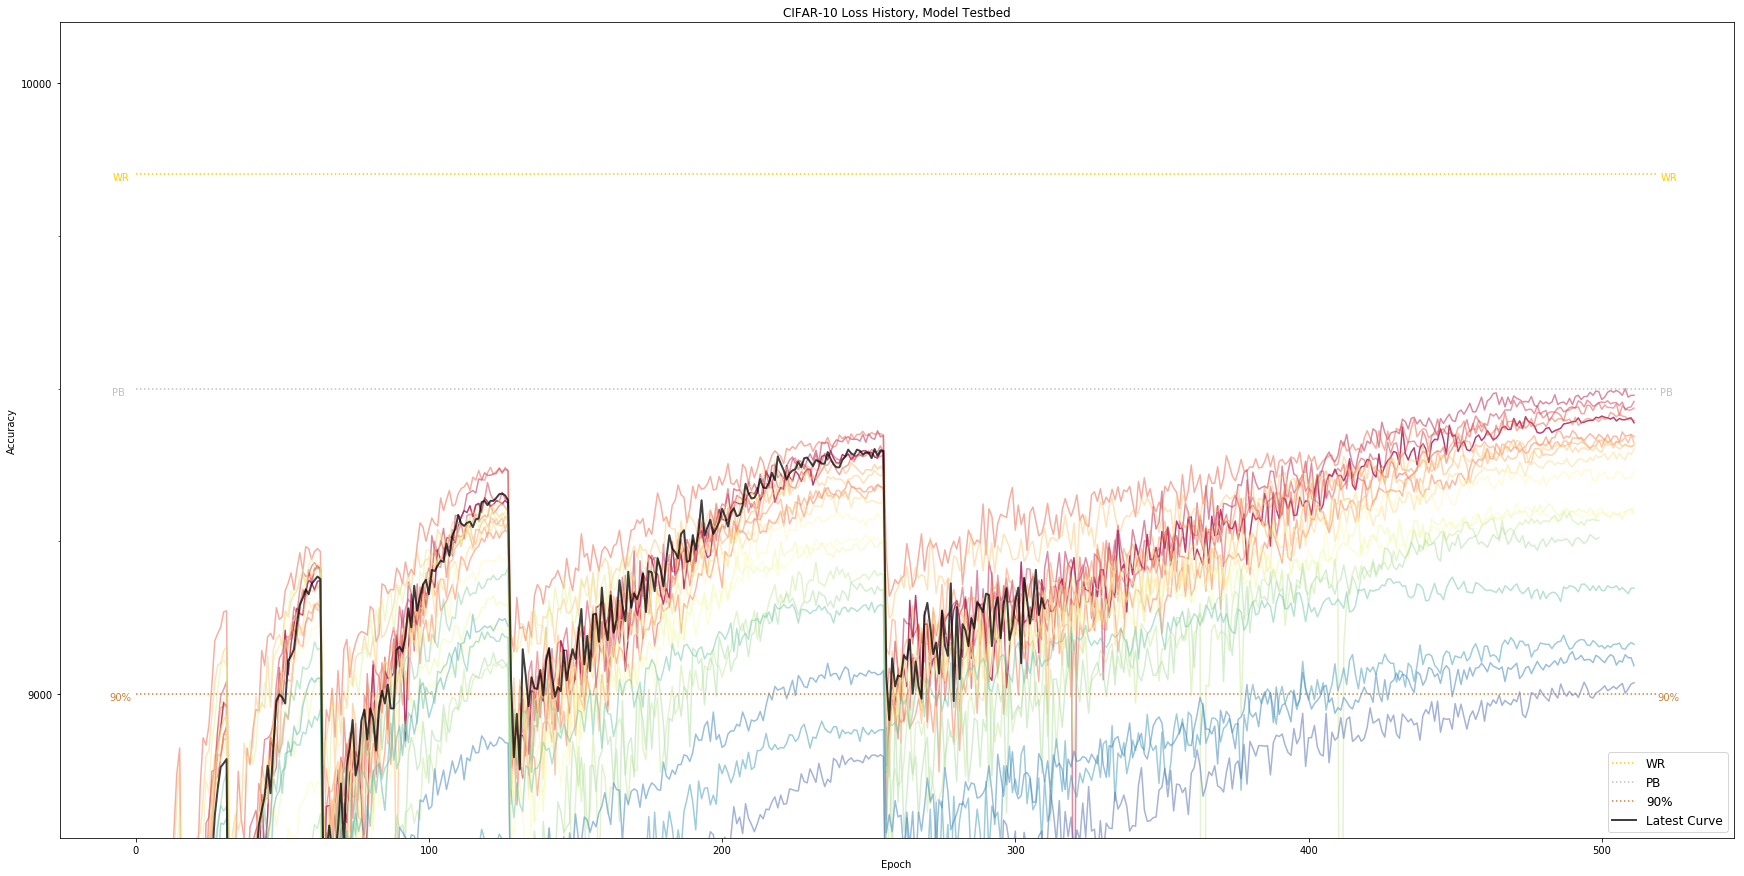

In [ ]:
while 1:
    try:
        last = macro_process(parse(last=True)).iloc[0]
    except IndexError as e:
        time.sleep(10)
        continue
        
    t = last['epoch']
    t_rec = min(t,len(record['curve']))
    plots = ['min'] if max(last['curve'])<9000 else ['min',None]
    for ylim in plots:
        plt.figure(figsize=(30,15))

        # plot top runs
        best_runs = []
        cm = plt.cm.Spectral
        for idx,(_,row) in enumerate(best_run_df.iterrows()):
            plt.plot(row['curve'][:512],alpha=(.75 if idx==0 else .5),color=cm(idx/len(best_run_df)))
            best_runs.append(row['curve'])

        # plot benchmarks
        for bm in [(9852,'WR','#ffcc00'),(record['max'],'PB','#c0c0c0'),(9000,'90%','#cd7f32')]:
            benchmark(*bm)

        # plot latest run
        plt.plot(last['curve'],color='k',linewidth=2,alpha=.75,label='Latest Curve')

        # grab some useful measures
        record_maxes,last_maxes = cumul_max(record['curve']), cumul_max(last['curve'])
        print(min(len(record_maxes),t))
        record_max,  last_max   = record_maxes[t-1],last_maxes[-1]
        record_currs,last_currs = np.array(record['curve']),np.array(last['curve'])
        record_curr,last_curr   = record_currs[t-1],last_currs[t-1]

        print("Epoch {}, Current Score: {}, Max Score: {}, Record Score: {}".format(t,last_curr,last_max,record_maxes[-1]))
        print("Current Record Delta:     {:>4} ({} vs {})".format(del_str(last_curr-record_curr),last_curr,record_curr),end="")

        if t>10:
            print(", Average T-10 Delta: {}".format(del_str(np.mean(last_currs[t-10:t]-record_currs[t-10:t]) )))
        else:
            print()
        print("Current Record Max Delta: {:>4} ({} vs {})".format(del_str(last_max-record_max),last_max,record_max))
        print("Average Delta to Restart:",restart_delta(best_runs,t))
        print("Record  Delta to Restart:",restart_delta([record['curve']],t))

        # label
        plt.title("CIFAR-10 Loss History, Model Testbed")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        ax = plt.gca()
        
        if ylim=='min':
            plt.ylim(min([x[min(t,len(x)-1)] for x in best_runs]),10100)
            ax.yaxis.set_major_locator(MultipleLocator(1000))
            ax.yaxis.set_minor_locator(MultipleLocator(250))
        else:
            plt.ylim(9000,10100)
            ax.yaxis.set_major_locator(MultipleLocator(200))
            ax.yaxis.set_minor_locator(MultipleLocator(50))
            plt.grid(axis='y',alpha=.2)
            
        plt.legend(loc='lower right',fontsize=12)
        plt.show()
    
        while parse(last=True).iloc[0]['epoch'] == t:
            time.sleep(5)
        clear_output()